<a href="https://colab.research.google.com/github/fedhere/MLPNS2021/blob/main/HW3_LinearRegression/FitLineToGRBAfterGlow_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
#This stylesheet changes the default parameters stored in the ictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLPNS2021/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)   

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/MLPNS2021

/content/drive/MyDrive/MLPNS2021


In [4]:
grbAG = pd.read_csv("grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [5]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


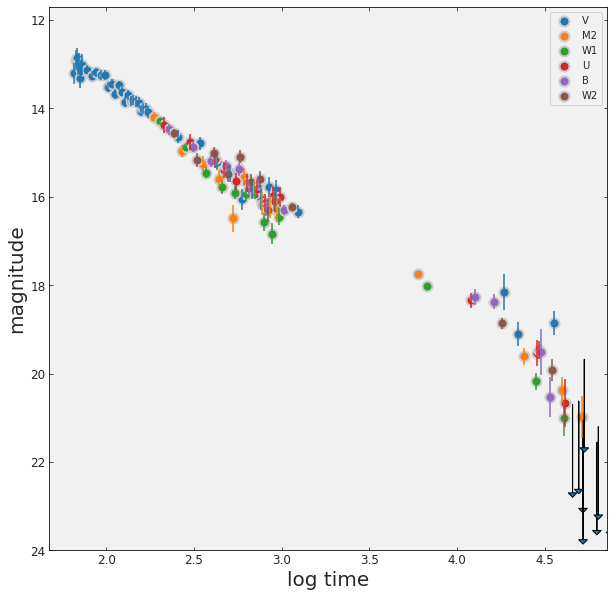

In [6]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 
To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```



In [9]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))


best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    return slope * x + intercept
def l1(args, x, y):
    a, b = args
    return sum(np.abs(y - line(a, b, x)))


initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.303341474745576
 hess_inv: array([[ 5.63862864e-04, -1.25020978e-04],
       [-1.25020978e-04,  2.82770660e-05]])
      jac: array([1.53180313, 6.77090526])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 564
      nit: 14
     njev: 138
   status: 2
  success: False
        x: array([8.22522099, 2.64076519])

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [11]:
minimize?

In [12]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return sum((y - line(a, b, x))**2)


initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

      fun: 12.825987500725489
 hess_inv: array([[ 0.06254438, -0.02029726],
       [-0.02029726,  0.00711354]])
      jac: array([-1.19209290e-07, -3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([8.58266842, 2.51199977])

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [13]:
l2?


# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [14]:
def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(a, b, x))**2 / s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.42066980130915
 hess_inv: array([[ 0.00155852, -0.00054288],
       [-0.00054288,  0.0002017 ]])
      jac: array([0.00000000e+00, 8.01086426e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 216
      nit: 4
     njev: 51
   status: 2
  success: False
        x: array([8.59948749, 2.48019101])

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


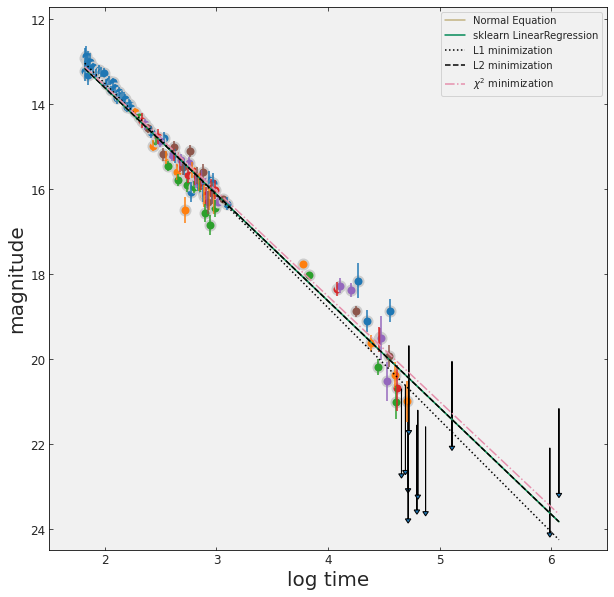

In [15]:
def plotline(pars, x, color='k', symbol='-', label='model', 
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime.values, 
         color='#'+colors[0], 
         label="Normal Equation", ax=ax)
#sklearn
plotline((theta_best[::-1]), grbAG.logtime,  
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,  
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,  
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime, 
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# Create a table with the results of each method
(see here for table syntax in markdown) https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables

|method | slope | intercept |
|- | -| -| 
| Normal Equation| 2.51 |8.58  |
|sklearn.LinearRegression()| 2.51 |8.58  |
| minimize L1|2.64 | 8.23
| minimize L2|2.51 | 8.58
| minimize chi2|2.50|  8.58 | 

# now try a broken power law with MCMC



$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{x}{T_b})^{-a2}) $

In [16]:
!pip install emcee

In [17]:
import emcee

In [18]:
emcee

<module 'emcee' from '/usr/local/lib/python3.7/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

In [50]:
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  return -np.inf


In [51]:
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [52]:
def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf 
  
  return lp + log_likelihood(theta, x, y, yerr)

In [53]:
#initial guess
ig = [1,10]

In [54]:
#initialize walkers
nwalkers = 32
ndim = len(ig)

In [55]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [56]:
pos.shape

(32, 2)

In [57]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s))

In [58]:
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 719.55it/s]


In [59]:
samples = sampler.get_chain()

In [60]:
samples.shape

(5000, 32, 2)

In [61]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [62]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46626718, 2.48015058, 2.49417637],
       [8.56120134, 8.59946609, 8.63847059]])

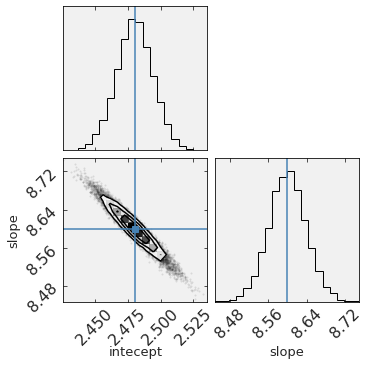

In [63]:
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


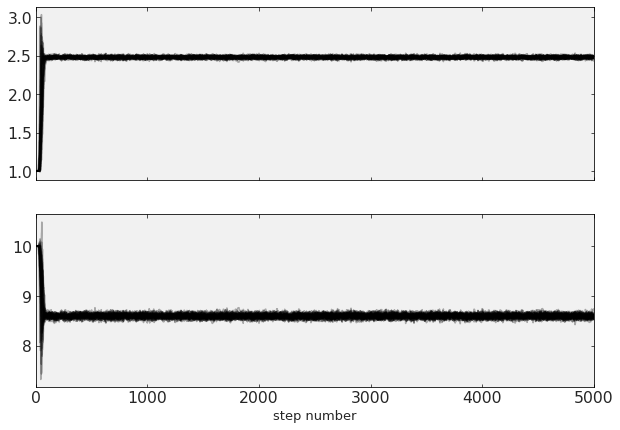

In [64]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

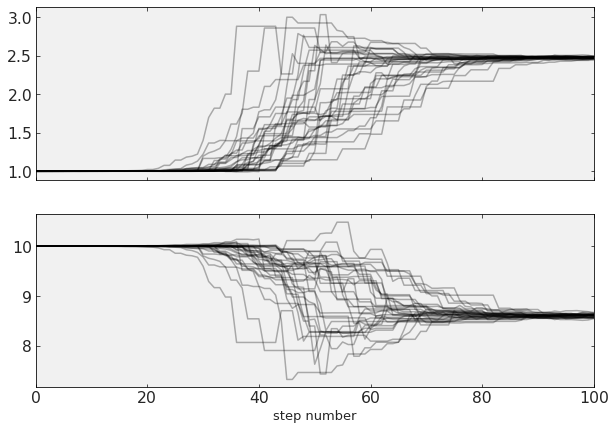

In [65]:
# zoom in: the beginnign of the chane should be cut
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [66]:
mcmc_line = mcmc

look at documentation: https://emcee.readthedocs.io/en/stable/

In [67]:
x_nolog = grbAG[grbAG.upperlimit == 0].time.values

In [68]:
def bpl (theta, x):
    a1, a2, Tb, b = theta
    return b - np.log10((x/Tb)**(-a1) + (x/Tb)**(-a2))
def log_likelihood_bpl(theta, x, y, yerr):
    return -np.sum(((y - bpl(theta, x))**2) / yerr**2)


In [69]:
x_nolog.min(), x_nolog.max()

(66, 51257)

In [70]:
def log_prior_bpl(theta):
    a1, a2, Tb, b = theta
    if a1 > 0 and a2 > 0 and b > 0 and  x_nolog.min() < Tb <  x_nolog.max():
        return 0.0
    return -np.inf

def log_probability_bpl(theta, x, y, yerr):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf 
  
  return lp + log_likelihood_bpl(theta, x, y, yerr)

In [71]:

nll = lambda *args: -log_likelihood_bpl(*args)
ig = [0.2, 5, 1000, 20]

soln = minimize(nll, ig, args=(x_nolog, y, s))
soln

      fun: 217.4653148061869
 hess_inv: array([[ 0.01338726, -0.00258176, -0.02678465,  0.00175664],
       [-0.00258176,  0.00070347,  0.0048172 , -0.00041109],
       [-0.02678465,  0.0048172 ,  0.05433035, -0.00342656],
       [ 0.00175664, -0.00041109, -0.00342656,  0.00034364]])
      jac: array([5.53131104e-05, 4.00543213e-05, 1.90734863e-05, 1.33514404e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1098
      nit: 69
     njev: 181
   status: 2
  success: False
        x: array([  3.54790516,   2.1456743 , 273.61857641,  15.04731019])

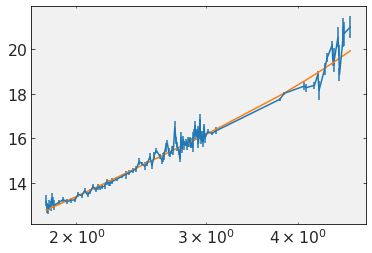

In [72]:
ig = soln.x

pl.errorbar(x, y, yerr=s)
pl.plot(x, bpl(ig, x_nolog))
pos = np.array(ig) + 1e-4 * np.random.randn(32, len(ig))
nwalkers, ndim = pos.shape
labels = ["intercept","slope"]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_bpl, args=(x, y, s))
pl.xscale("log")

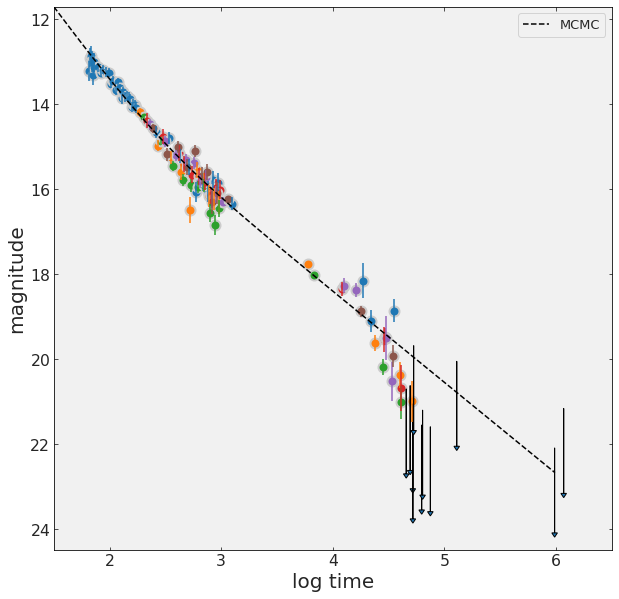

In [73]:

ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01), 
        bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k", 
        label="MCMC")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

In [74]:
 sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:13<00:00, 374.01it/s]


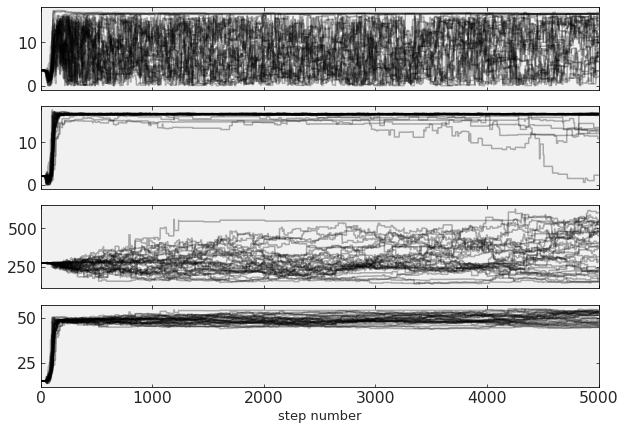

In [75]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [76]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84])
    
mcmc[:,1]

array([  9.48345712,  16.57953702, 275.33396202,  48.90218238])

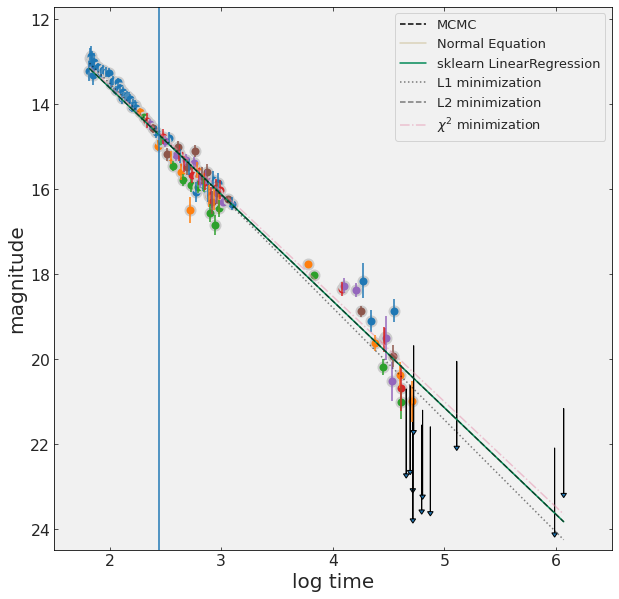

In [77]:

ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1], 
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime.values, 
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((theta_best[::-1]), grbAG.logtime,  
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,  
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,  
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime, 
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

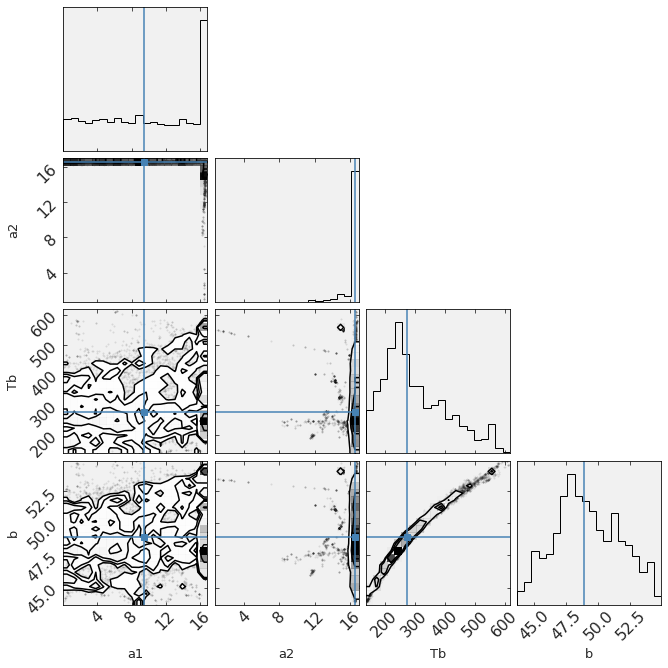

In [78]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



# Model selection

In [80]:
log_likelihood(mcmc_line[:,1], x, y, s)

-317.42076095842975

In [81]:
log_likelihood_bpl(mcmc[:,1], x_nolog, y, s)

-6460625.723054005

In [83]:
-2*(6460625.723054005 - 317.42076095842975)

-12920616.604586093

In [114]:
def aic(x, l, k):
  return  2 / len(x) * (l + k) 


def bic(x, l, k):
  return  2 * l + np.log(len(x)) * k 


In [115]:
print("AIC line {} AIC bpl {}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2), 
                                      aic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

print("BIC line {} BIC bpl {}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2), 
                                      bic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

AIC line -5.841125202933884 AIC bpl -119641.1430195186
BIC line -625.4772594626111 BIC bpl -12921232.717583101


In [116]:
# redefine chi2 to take a n deg polynomial 

[319.42066980130915, 247.9536015087419, 207.71963636728324, 180.22814751063194, 181.11721964686663, 181.2355547817711] [224.0192423242268, 175.78889825378883, 149.20769157267966, 131.45889640173672, 133.38200706572226, 134.77088355028252]


Text(0.5, 0, 'n params')

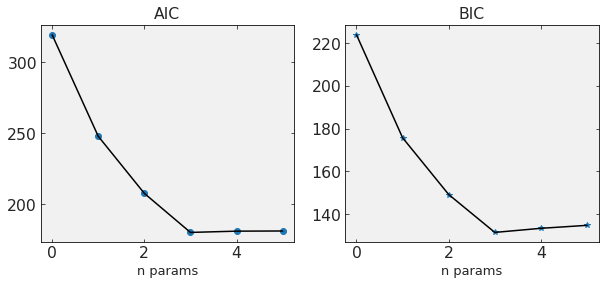

In [117]:
def poly(x, pars):
    #print (pars)
    res = 0
    for i,p in enumerate(pars):
        res += p * pow(x, i)
    return res 
    
def chi2(args, x, y, s):
    return sum((y - poly(x, args))**2 / s**2)

initialGuess = [10]
aics, bics = [], []
ls = []
for i in range(6):
  initialGuess = initialGuess + [1]

  chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
  aics.append(aic(x[::70], len(initialGuess), chi2Solution.fun))
  bics.append(bic(x[::70], len(initialGuess), chi2Solution.fun))

print(aics, bics)
fig = pl.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1  .set_title("AIC")
ax1.plot(aics, 'o')
ax1.plot(aics, 'k-')
ax1.set_xlabel("n params")
ax2 = fig.add_subplot(122)
ax2.set_title("BIC")
ax2.plot(bics, '*')
ax2.plot(bics, 'k-')
ax2.set_xlabel("n params")